# Proyek Pertama: Menyelesaikan Permasalahan Human Resources

- Nama: Monica Elisabeth Mamondol
- Email: bethlisa125@gmail.com
- Id Dicoding:monica_mamondol

## Persiapan

In [1]:
!pip install xgboost --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 5.3 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


### Menyiapkan library yang dibutuhkan

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import chi2_contingency

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as sklearn_confusion_matrix
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

### Menyiapkan data yang akan digunakan

In [3]:
dataset = "https://raw.githubusercontent.com/dicodingacademy/dicoding_dataset/refs/heads/main/employee/employee_data.csv"
df = pd.read_csv(dataset)

# **Data Understanding**

**Melihat 5 baris teratas dari dataset.**

In [4]:
df.head()

,EmployeeId,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,38,NaN,Travel_Frequently,1444,Human Resources,1,4,Other,1,...,2,80,1,7,2,3,6,2,1,2
1,2,37,1.0,Travel_Rarely,1141,Research & Development,11,2,Medical,1,...,1,80,0,15,2,1,1,0,0,0
2,3,51,1.0,Travel_Rarely,1323,Research & Development,4,4,Life Sciences,1,...,3,80,3,18,2,4,10,0,2,7
3,4,42,0.0,Travel_Frequently,555,Sales,26,3,Marketing,1,...,4,80,1,23,2,4,20,4,4,8
4,5,40,NaN,Travel_Rarely,1194,Research & Development,2,4,Medical,1,...,2,80,3,20,2,3,5,3,0,2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmployeeId                1470 non-null   int64  
 1   Age                       1470 non-null   int64  
 2   Attrition                 1058 non-null   float64
 3   BusinessTravel            1470 non-null   object 
 4   DailyRate                 1470 non-null   int64  
 5   Department                1470 non-null   object 
 6   DistanceFromHome          1470 non-null   int64  
 7   Education                 1470 non-null   int64  
 8   EducationField            1470 non-null   object 
 9   EmployeeCount             1470 non-null   int64  
 10  EnvironmentSatisfaction   1470 non-null   int64  
 11  Gender                    1470 non-null   object 
 12  HourlyRate                1470 non-null   int64  
 13  JobInvolvement            1470 non-null   int64  
 14  JobLevel

# **Exploratory Data Analysis**

**Mengecek missing value**

In [6]:
df.isnull().sum()[df.isnull().sum() > 0]

,0
Attrition,412


**Mengecek duplikasi pada dataset**

In [7]:
duplicate_count = df.duplicated().sum()
print("Jumlah duplikasi: ", duplicate_count)

Jumlah duplikasi:  0


**Insight:**
- Total baris: 1,470
- Total kolom: 35
- Fitur target Attrition memiliki 412 missing value.
- Tidak ada data yang terduplikat.
- Tipe data terdiri dari numerik (float64(1), int64(26)), dan kategorikal (object(8)).

### **Analisis Distribusi Target**

**Analisis distribusi kelas 0 dan 1 pada target `Attrition`**

In [8]:
attrition_counts = df['Attrition'].value_counts()
attrition_counts

,count
Attrition,
0.0,879
1.0,179


In [9]:
attrition_percentage = df['Attrition'].value_counts(normalize=True) * 100
attrition_percentage

,proportion
Attrition,
0.0,83.081285
1.0,16.918715


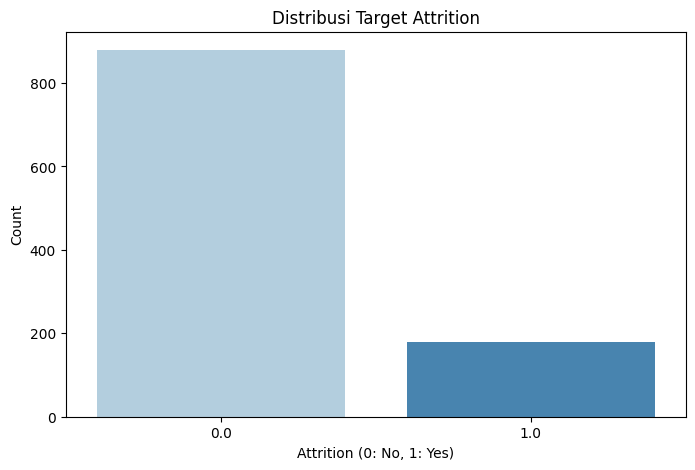

In [10]:
# Visualisasi Distribusi Target
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Attrition', palette="Blues")
plt.title("Distribusi Target Attrition")
plt.xlabel("Attrition (0: No, 1: Yes)")
plt.ylabel("Count")
plt.show()

**Insight:**
- 0 (Tidak Keluar): 83,08%
- 1 (Keluar): 16,92%

Artinya, sebagian besar karyawan tidak keluar, tetapi Attrition tetap signifikan pada 16.92% karyawan.

### **Analisis Fitur Numerik**

In [11]:
# Distribusi Variabel Numerik
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns

['EmployeeId',
 'Age',
 'Attrition',
 'DailyRate',
 'DistanceFromHome',
 'Education',
 'EmployeeCount',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobSatisfaction',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StandardHours',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [12]:
numerical_description = df[numerical_columns].describe()
numerical_description

,EmployeeId,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1058.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,735.500000,36.923810,0.169187,802.485714,9.192517,2.912925,1.0,2.721769,65.891156,2.729932,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,424.496761,9.135373,0.375094,403.509100,8.106864,1.024165,0.0,1.093082,20.329428,0.711561,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,1.000000,18.000000,0.000000,102.000000,1.000000,1.000000,1.0,1.000000,30.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,368.250000,30.000000,0.000000,465.000000,2.000000,2.000000,1.0,2.000000,48.000000,2.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,735.500000,36.000000,0.000000,802.000000,7.000000,3.000000,1.0,3.000000,66.000000,3.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,1102.750000,43.000000,0.000000,1157.000000,14.000000,4.000000,1.0,4.000000,83.750000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,1470.000000,60.000000,1.000000,1499.000000,29.000000,5.000000,1.0,4.000000,100.000000,4.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


### **Visualisasi Distribusi Kolom Numerik**

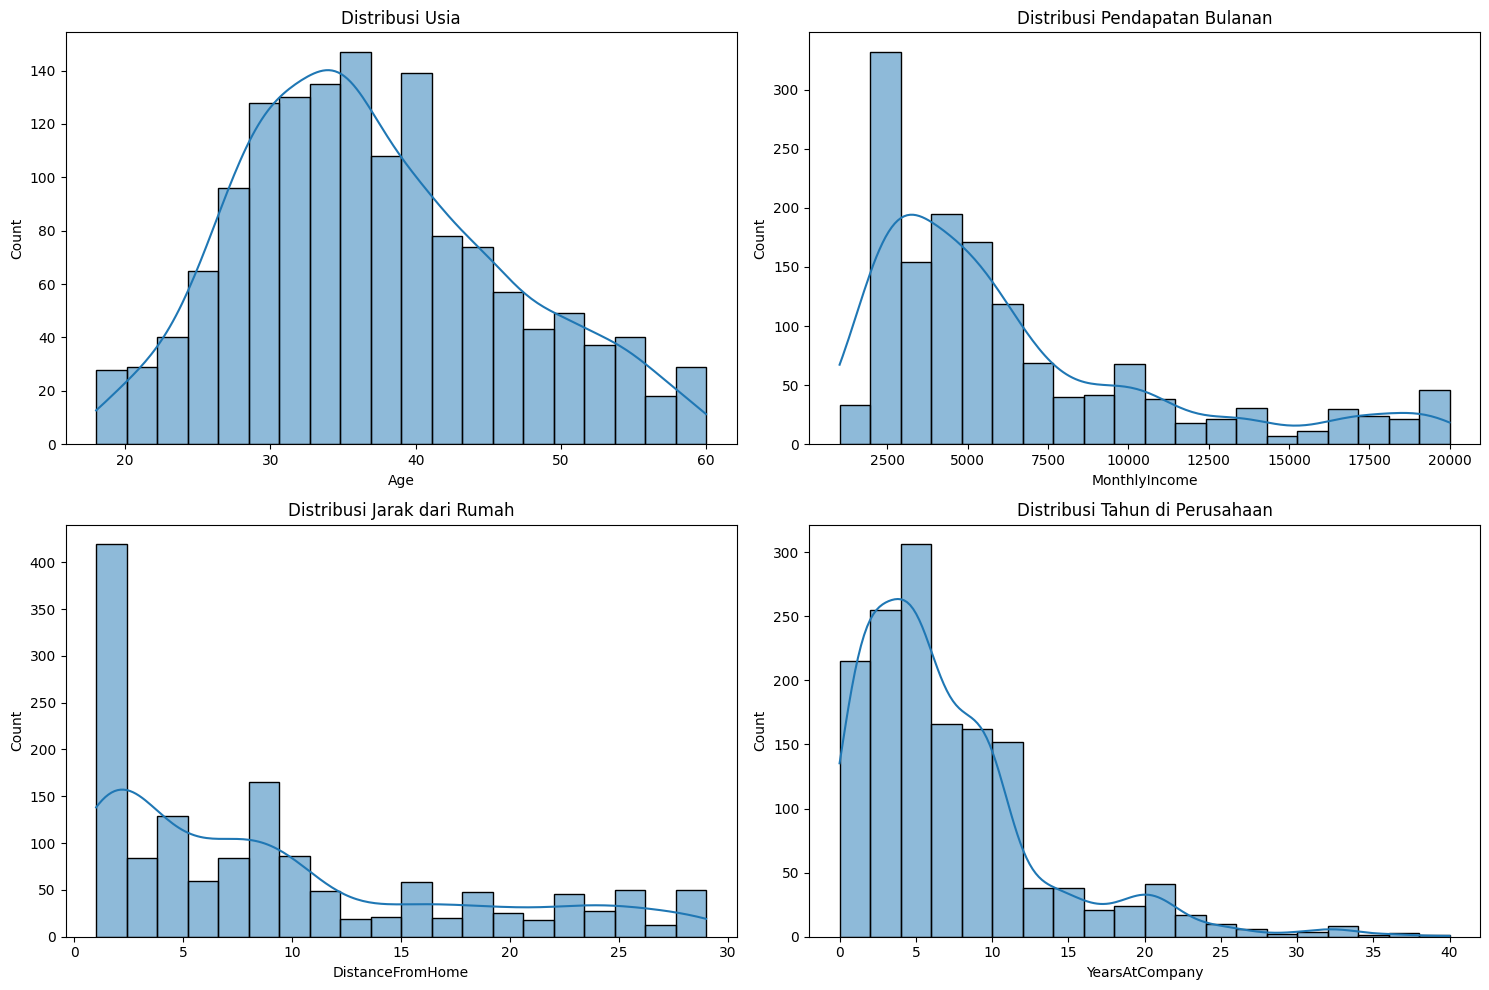

In [13]:
# Visualisasi Distribusi Kolom Numerik
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
sns.histplot(df['Age'], bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Distribusi Usia")

sns.histplot(df['MonthlyIncome'], bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Distribusi Pendapatan Bulanan")

sns.histplot(df['DistanceFromHome'], bins=20, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Distribusi Jarak dari Rumah")

sns.histplot(df['YearsAtCompany'], bins=20, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Distribusi Tahun di Perusahaan")

plt.tight_layout()
plt.show()

**Insight:**
- `Age`: Rata-rata usia adalah 36.9 tahun.
- `MonthlyIncome`: Pendapatan bulanan bervariasi dari min 1,000 hingga 19,000.
- `DistanceFromHome`: Sebagian besar karyawan tinggal dekat dengan kantor (jarak rata-rata 9 km).
- `YearsAtCompany`: Sebagian besar karyawan bekerja di perusahaan selama 5-9 tahun.

### **Analisis Hubungan Fitur Numerik terhadap target `Attrition`**

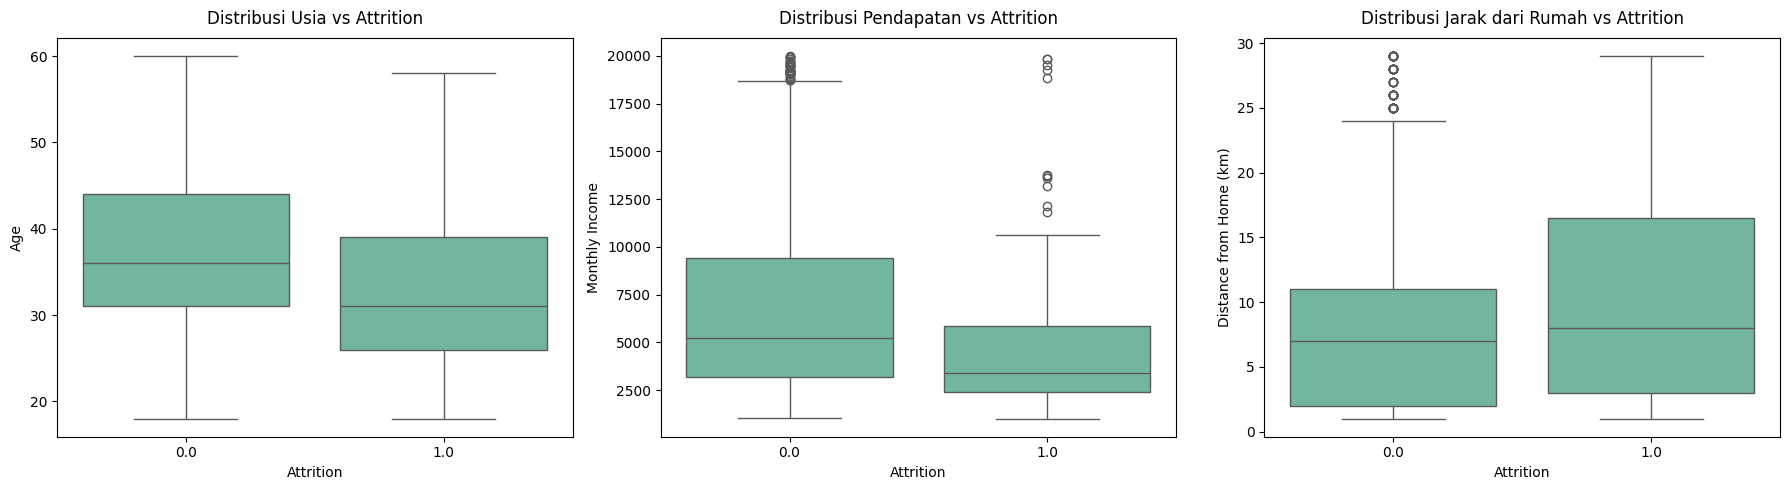

In [14]:
# Set style
sns.set_palette("Set2")

# Create figure dengan 3 subplots dalam 1 baris
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Age
sns.boxplot(data=df, x='Attrition', y='Age', ax=axes[0])
axes[0].set_title("Distribusi Usia vs Attrition", pad=10)
axes[0].set_xlabel("Attrition")
axes[0].set_ylabel("Age")

# Plot 2: MonthlyIncome
sns.boxplot(data=df, x='Attrition', y='MonthlyIncome', ax=axes[1])
axes[1].set_title("Distribusi Pendapatan vs Attrition", pad=10)
axes[1].set_xlabel("Attrition")
axes[1].set_ylabel("Monthly Income")

# Plot 3: DistanceFromHome
sns.boxplot(data=df, x='Attrition', y='DistanceFromHome', ax=axes[2])
axes[2].set_title("Distribusi Jarak dari Rumah vs Attrition", pad=10)
axes[2].set_xlabel("Attrition")
axes[2].set_ylabel("Distance from Home (km)")

plt.tight_layout()
plt.show()

**Insight:**
- Kolom `Age`: Karyawan dengan Attrition cenderung lebih muda dibandingkan karyawan yang tidak keluar.
- Kolom `MonthlyIncome`: Karyawan dengan Attrition memiliki distribusi pendapatan yang lebih rendah dibandingkan karyawan yang bertahan.
- Kolom `DistanceFromHome`: Tidak ada perbedaan signifikan dalam jarak rumah terhadap kantor antara karyawan yang keluar dan yang bertahan.

### **Distribusi YearsAtCompany dan TotalWorkingYears**

Menganalisis distribusi kolom `YearsAtCompany` dan `TotalWorkingYears` karena fitur ini relevan dalam memengaruhi `Attrition`

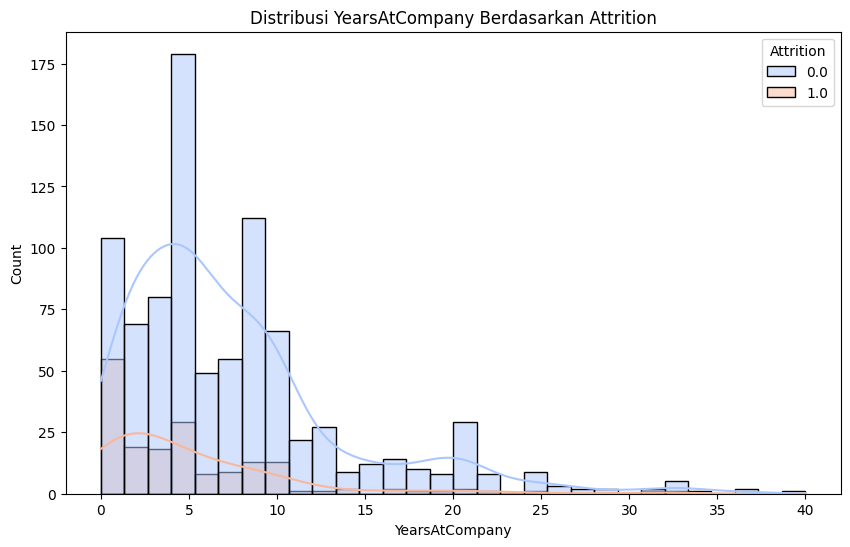

In [15]:
# Visualisasi distribusi YearsAtCompany untuk Attrition
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="YearsAtCompany", hue="Attrition", kde=True, palette="coolwarm", bins=30)
plt.title("Distribusi YearsAtCompany Berdasarkan Attrition")
plt.xlabel("YearsAtCompany")
plt.ylabel("Count")
plt.show()

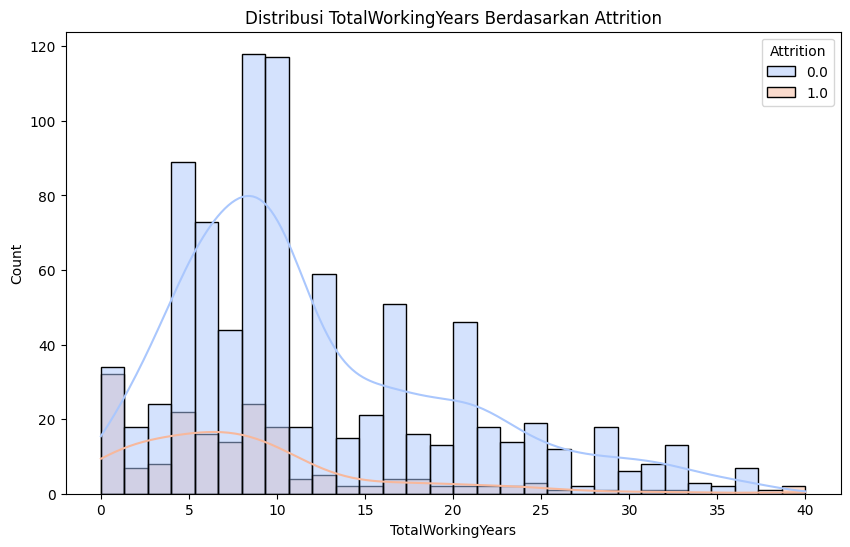

In [16]:
# Visualisasi distribusi TotalWorkingYears untuk Attrition
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="TotalWorkingYears", hue="Attrition", kde=True, palette="coolwarm", bins=30)
plt.title("Distribusi TotalWorkingYears Berdasarkan Attrition")
plt.xlabel("TotalWorkingYears")
plt.ylabel("Count")
plt.show()

**Insight:**

Berdasarkan distribusi kolom `YearsAtCompany` dan `TotalWorkingYears` terhadap `Attrition`:

1. `YearsAtCompany`:
- Karyawan dengan masa kerja singkat (sekitar 0-5 tahun) memiliki risiko `Attrition` lebih tinggi.
- Distribusi menunjukkan bahwa karyawan baru cenderung keluar lebih cepat.
2. `TotalWorkingYears`:
-  Dengan pengalaman kerja lebih sedikit (0-10 tahun) lebih sering keluar dibandingkan yang memiliki pengalaman kerja lebih panjang.
- Ini menunjukkan pentingnya retensi awal karir dan pengembangan karyawan.

### **Analisis Interaksi Antar Fitur**

Analisis untuk melihat hubungan antara dua fitur utama dan bagaimana mereka berinteraksi dengan target `Attrition`.

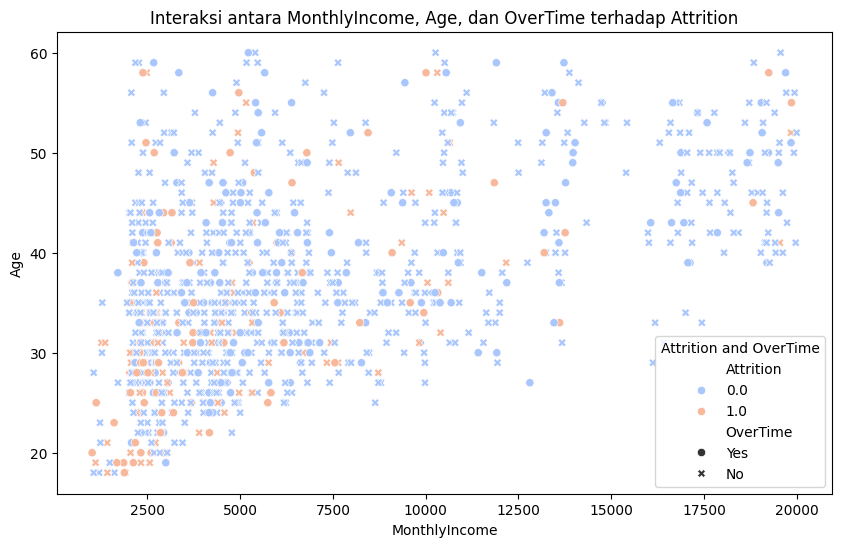

In [17]:
# Visualisasi interaksi antara MonthlyIncome dan OverTime terhadap Attrition
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="MonthlyIncome", y="Age", hue="Attrition", style="OverTime", palette="coolwarm")
plt.title("Interaksi antara MonthlyIncome, Age, dan OverTime terhadap Attrition")
plt.xlabel("MonthlyIncome")
plt.ylabel("Age")
plt.legend(title="Attrition and OverTime")
plt.show()

**Insight:**

Grafik di atas menggambarkan interaksi antara kolom `MonthlyIncome`, `Age` dan `Overtime` terhadap `Attrition`.

1. `Attrition` dan `OverTime`
- Karyawan yang sering lembur (ditandai dengan simbol *) lebih cenderung mengalami `attrition` (ditandai dengan warna oranye) dibandingkan yang tidak lembur.
2. `Attrition` dan `MonthlyIncome`
- Karyawan dengan pendapatan bulanan yang lebih rendah memiliki proporsi `Attrition` yang lebih tinggi dibandingkan dengan berpendapatan lebih tinggi.
- Ini terlihat dari distribusi titik oranye yang lebih padat di bagian kiri grafik (`MonthlyIncome` rendah).
3. `Attrition` dan `Age`
- `Attrition` lebih sering terjadi pada karyawan yang lebih muda, terlihat dari titik-titik oranye yang terkonsentrasi di bagian bawah grafik (`Age` rendah)
4. Interaksi Ketiga Variabel
- Karyawan muda dengan pendapatan rendah dan sering lembur menunjukkan kecenderungan `attrition` yang lebih tinggi.

### **Analisis Tingkat Kepuasan Karyawan**

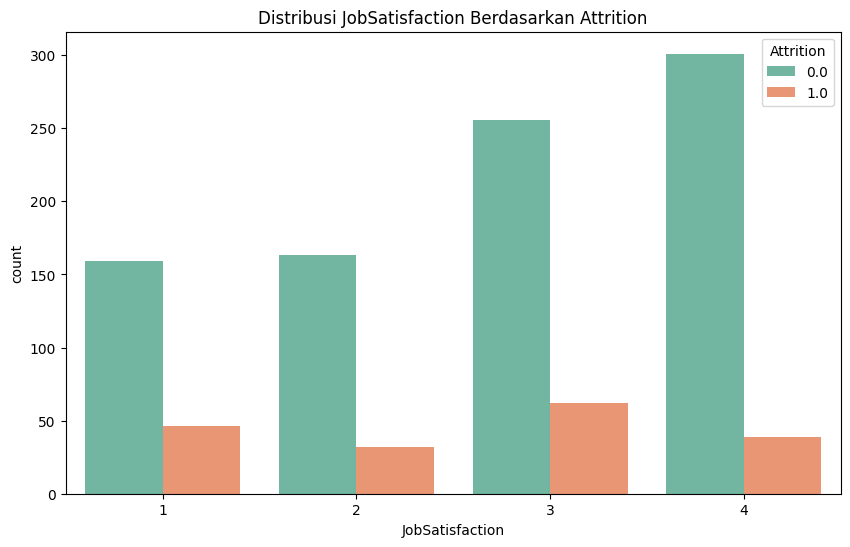

In [18]:
# Visualisasi Distribusi JobSatisfaction Berdasarkan Attrition
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='JobSatisfaction', hue='Attrition')
plt.title('Distribusi JobSatisfaction Berdasarkan Attrition')
plt.show()

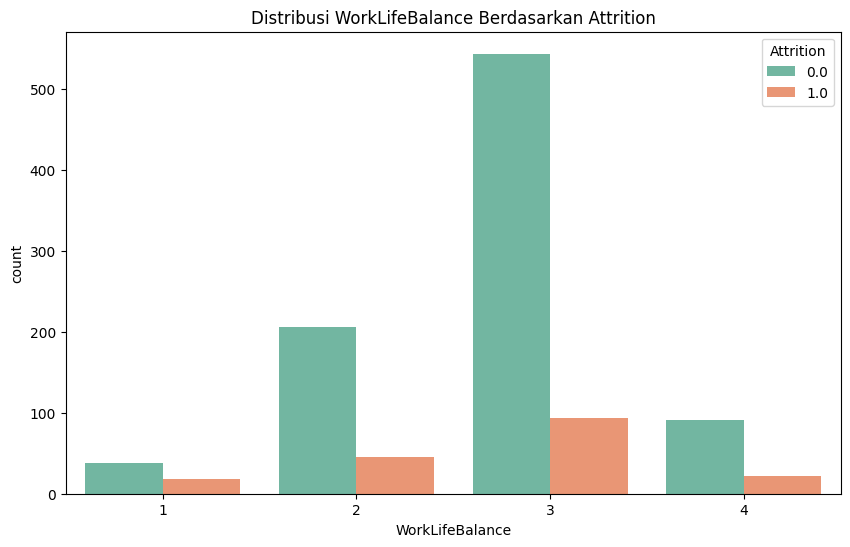

In [19]:
# Visualisasi WorkLifeBalance Berdasarkan Attrition
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='WorkLifeBalance', hue='Attrition')
plt.title('Distribusi WorkLifeBalance Berdasarkan Attrition')
plt.show()

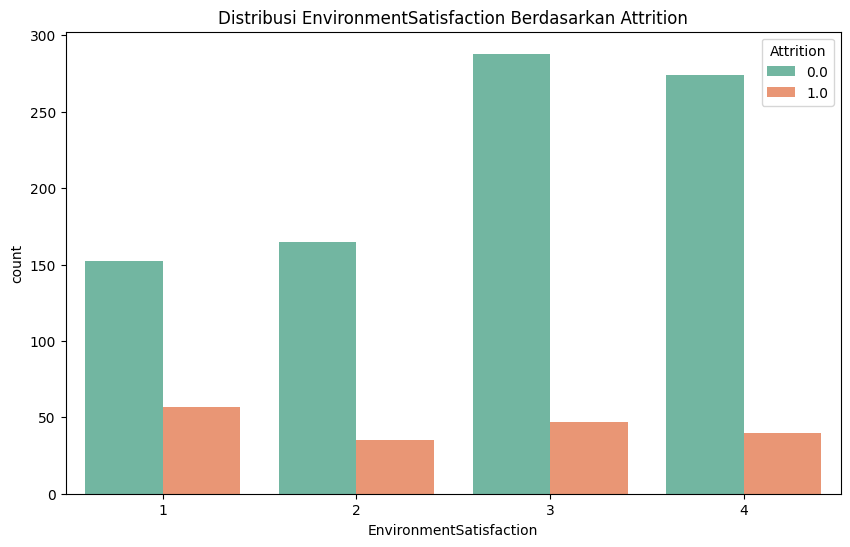

In [20]:
# Visualisasi Distribusi EnvironmentSatisfaction Berdasarkan Attrition
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='EnvironmentSatisfaction', hue='Attrition')
plt.title('Distribusi EnvironmentSatisfaction Berdasarkan Attrition')
plt.show()

### **Hubungan Fitur Kategorikal terhadap Target**           

In [21]:
categorical_columns = df.select_dtypes(exclude=[np.number]).columns.tolist()
categorical_columns

['BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'Over18',
 'OverTime']

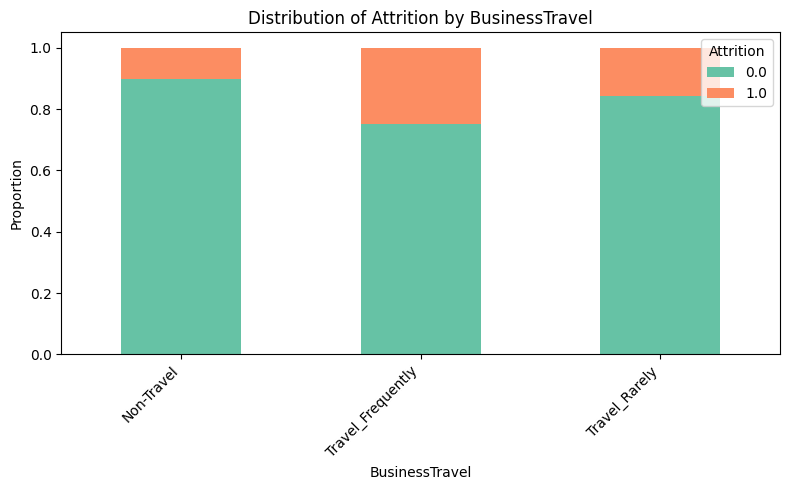

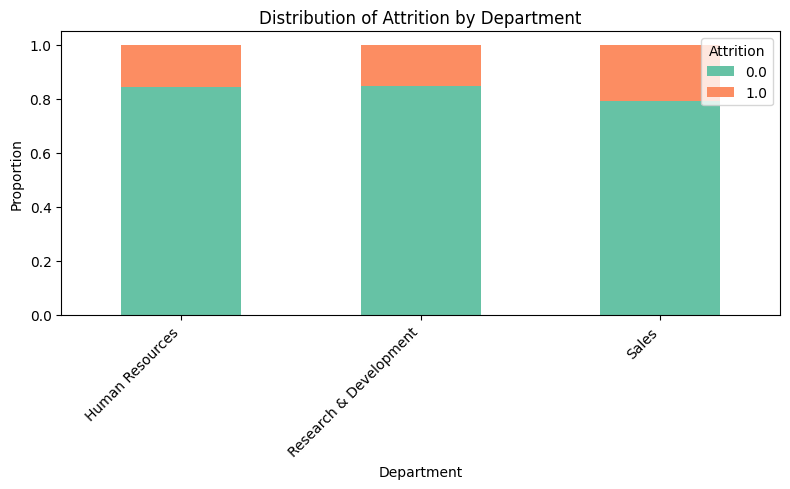

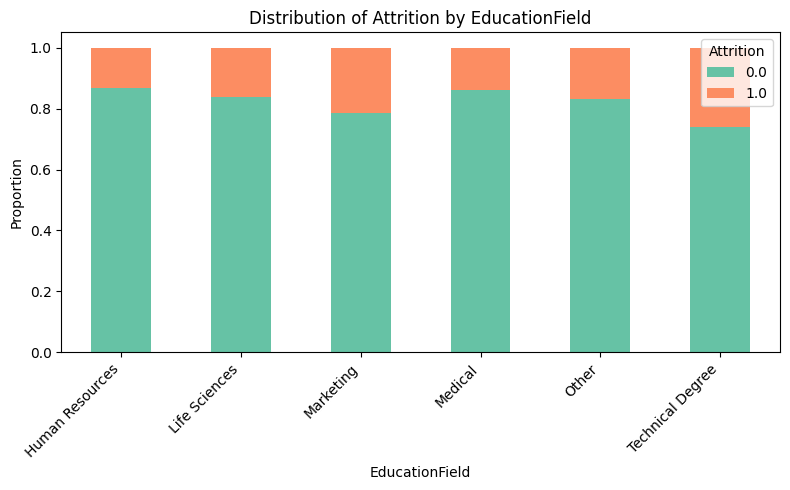

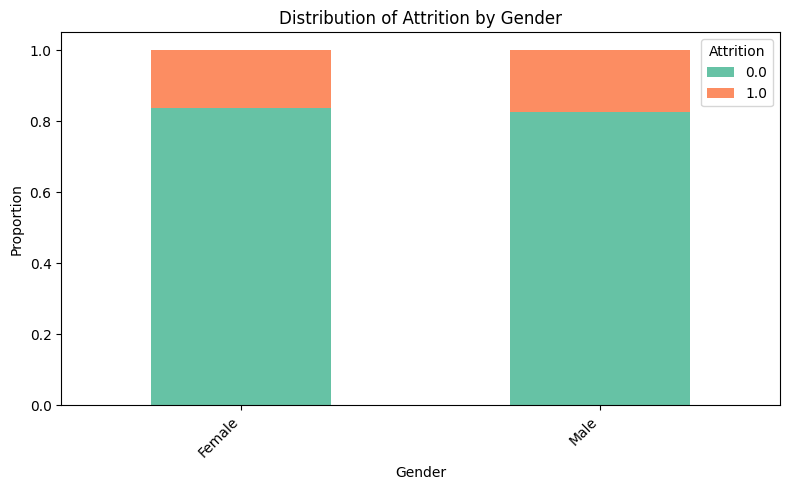

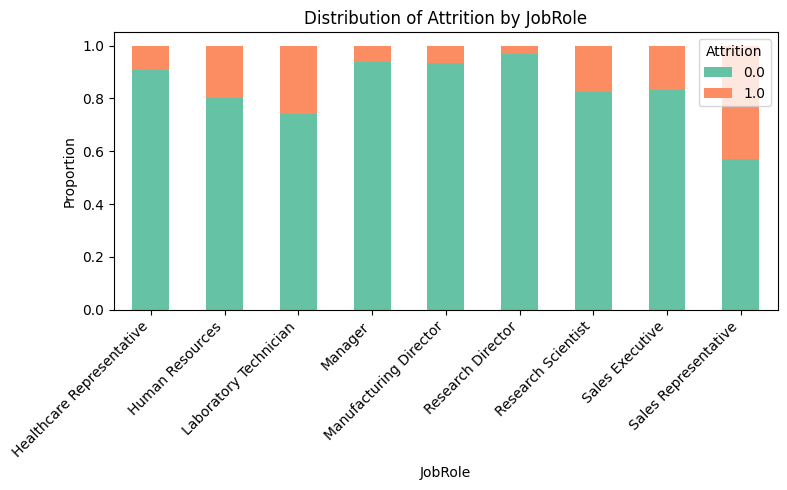

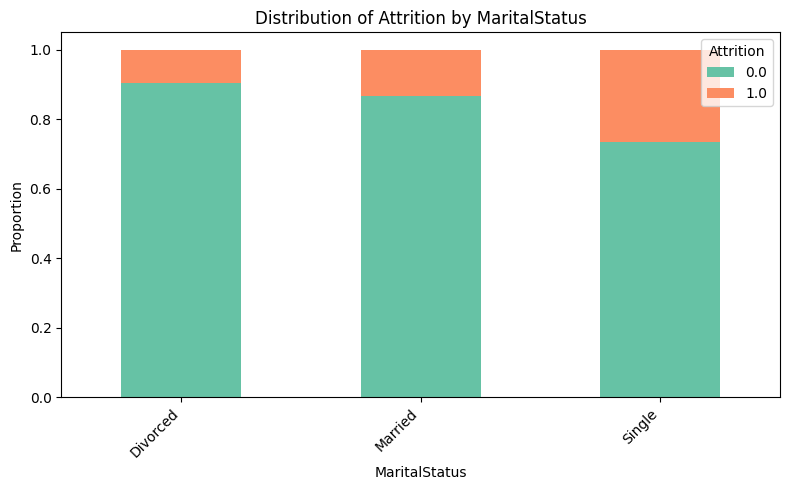

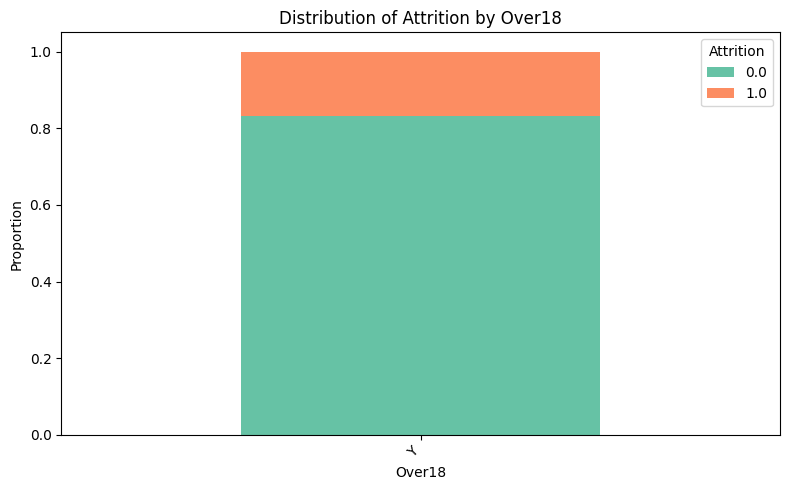

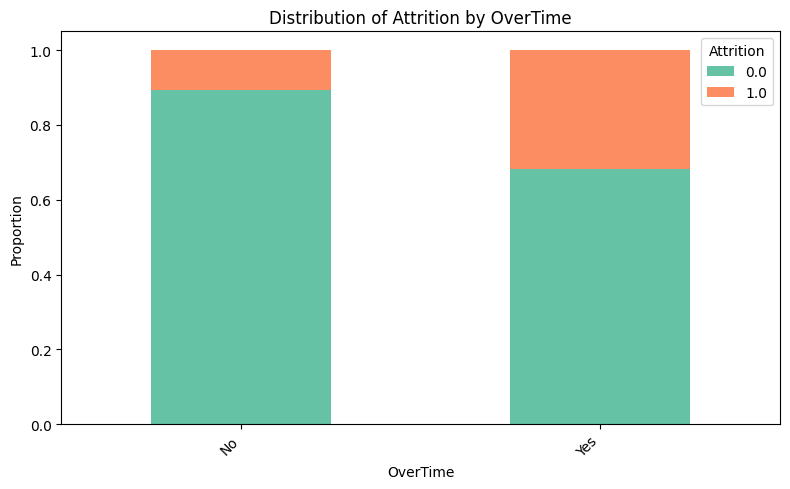

In [22]:
# Visualisasi Distribusi kolom kategorikal terhadap Attrition
for feature in categorical_columns:
    contingency_table = pd.crosstab(df[feature], df['Attrition'])
    contingency_table.div(contingency_table.sum(1), axis=0).plot(kind='bar', stacked=True, figsize=(8, 5))
    plt.title(f"Distribution of Attrition by {feature}")
    plt.ylabel("Proportion")
    plt.xlabel(feature)
    plt.legend(title="Attrition", loc="upper right")
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

**Insight:**

- `OverTime`: Karyawan yang sering lembur (`OverTime` = Yes) memiliki proporsi attrition yang jauh lebih tinggi.
- `MaritalStatus`: Karyawan single lebih rentan keluar dibandingkan yang sudah menikah atau bercerai.
- `JobRole`: Beberapa peran, seperti Sales Representative dan Laboratory Technician, memiliki `attrition` yang tinggi.
- `BusinessTravel`: Karyawan yang sering melakukan perjalanan bisnis memiliki risiko keluar lebih tinggi dibandingkan kategori lainnya.

### **Chi-Square Test**

In [23]:
chi_square_results = []
for feature in categorical_columns:
    # Create a contingency table
    contingency_table = pd.crosstab(df[feature], df['Attrition'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_square_results.append({
        "Feature": feature,
        "Chi-Square Statistic": chi2,
        "p-value": p
    })

In [24]:
# Convert results into DataFrame
chi_square_df = pd.DataFrame(chi_square_results)

In [25]:
chi_square_df

,Feature,Chi-Square Statistic,p-value
0,BusinessTravel,13.403348,1.228853e-03
1,Department,4.627283,9.890046e-02
2,EducationField,9.811529,8.075507e-02
3,Gender,0.187941,6.646360e-01
4,JobRole,66.393971,2.556695e-11
5,MaritalStatus,37.621652,6.769585e-09
6,Over18,0.000000,1.000000e+00
7,OverTime,67.763459,1.843342e-16


**Insight:**

1. Fitur Signifikan terhadap `Attrition` (p-value < 0.05):
- `BusinessTravel`: Karyawan dengan frekuensi perjalanan tertentu lebih cenderung keluar.
- `JobRole`: Peran pekerjaan tertentu memiliki hubungan signifikan dengan attrition.
- `MaritalStatus`: Status pernikahan memengaruhi risiko keluar, terutama pada karyawan single.
- `OverTime`: Karyawan yang sering lembur lebih cenderung keluar.

2. Fitur Tidak Signifikan (p-value >= 0.05):
- `Department`, `EducationField`, `Gender`, dan `Over18` tidak memiliki hubungan signifikan terhadap `attrition`.

### **Visualisasi Fitur Kategorikal terhadap `Attrition`**

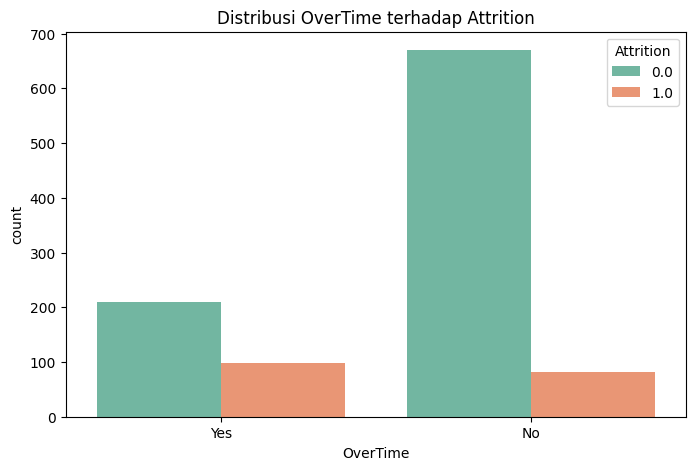

In [26]:
# Visualisasi Distribusi OverTime terhadap Attrition
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='OverTime', hue='Attrition', palette="Set2")
plt.title("Distribusi OverTime terhadap Attrition")
plt.show()

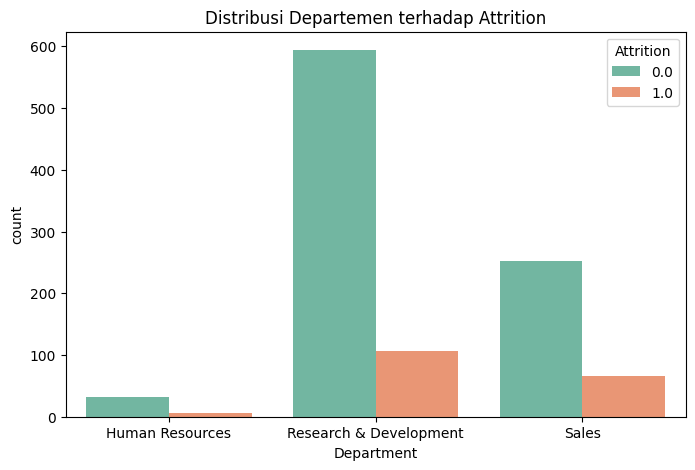

In [27]:
# Visualisasi Distribusi Department terhadap Attrition
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Department', hue='Attrition', palette="Set2")
plt.title("Distribusi Departemen terhadap Attrition")
plt.show()

### **Korelasi Antar Variabel**

**Mengecek korelasi antar kolom numerik**

In [28]:
correlation_matrix = df[numerical_columns].corr()
correlation_matrix

,EmployeeId,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
EmployeeId,1.000000,0.008841,-0.017912,0.026565,-0.018067,0.002476,NaN,-0.001820,0.004033,-0.032693,...,-0.018856,NaN,-0.037480,0.004460,0.040671,0.005567,-0.021971,-0.012364,-0.019815,-0.023632
Age,0.008841,1.000000,-0.172067,0.010661,-0.001686,0.208034,NaN,0.010146,0.024287,0.029820,...,0.053535,NaN,0.037510,0.680381,-0.019621,-0.021490,0.311309,0.212901,0.216513,0.202089
Attrition,-0.017912,-0.172067,1.000000,-0.051992,0.078074,-0.032631,NaN,-0.132848,-0.017524,-0.150196,...,-0.053417,NaN,-0.164228,-0.177137,-0.047859,-0.059556,-0.135134,-0.158757,-0.031944,-0.155962
DailyRate,0.026565,0.010661,-0.051992,1.000000,-0.004985,-0.016806,NaN,0.018355,0.023381,0.046135,...,0.007846,NaN,0.042143,0.014515,0.002453,-0.037848,-0.034055,0.009932,-0.033229,-0.026363
DistanceFromHome,-0.018067,-0.001686,0.078074,-0.004985,1.000000,0.021042,NaN,-0.016075,0.031131,0.008783,...,0.006557,NaN,0.044872,0.004628,-0.036942,-0.026556,0.009508,0.018845,0.010029,0.014406
Education,0.002476,0.208034,-0.032631,-0.016806,0.021042,1.000000,NaN,-0.027128,0.016775,0.042438,...,-0.009118,NaN,0.018422,0.148280,-0.025100,0.009819,0.069114,0.060236,0.054254,0.069065
EmployeeCount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EnvironmentSatisfaction,-0.001820,0.010146,-0.132848,0.018355,-0.016075,-0.027128,NaN,1.000000,-0.049857,-0.008278,...,0.007665,NaN,0.003432,-0.002693,-0.019359,0.027627,0.001458,0.018007,0.016194,-0.004999
HourlyRate,0.004033,0.024287,-0.017524,0.023381,0.031131,0.016775,NaN,-0.049857,1.000000,0.042861,...,0.001330,NaN,0.050263,-0.002334,-0.008548,-0.004607,-0.019582,-0.024106,-0.026716,-0.020123
JobInvolvement,-0.032693,0.029820,-0.150196,0.046135,0.008783,0.042438,NaN,-0.008278,0.042861,1.000000,...,0.034297,NaN,0.021523,-0.005533,-0.015338,-0.014617,-0.021355,0.008717,-0.024184,0.025976


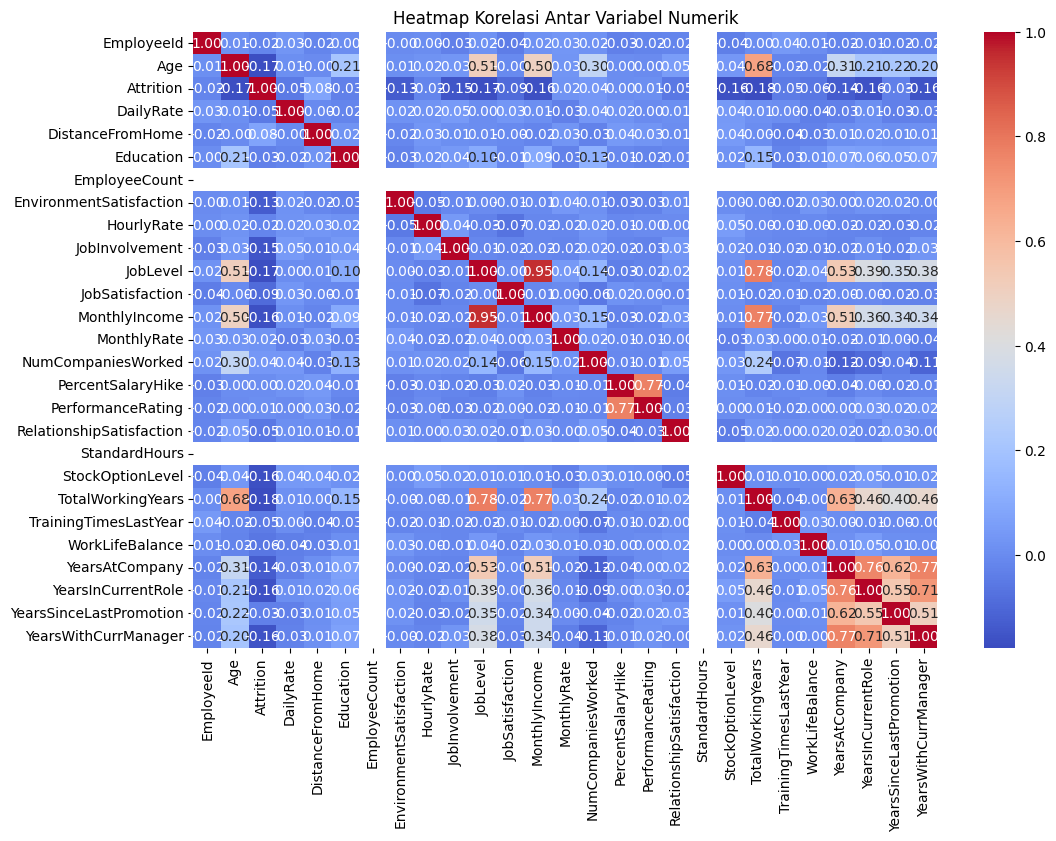

In [29]:
# Visualisasi Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap Korelasi Antar Variabel Numerik")
plt.show()

**Insight:**

`MonthlyIncome`, `TotalWorkingYears`, dan `YearsAtCompany` memiliki korelasi positif yang kuat (0.77).

**Analisis Korelasi antara Fitur Numerik dengan target `Attrition`**

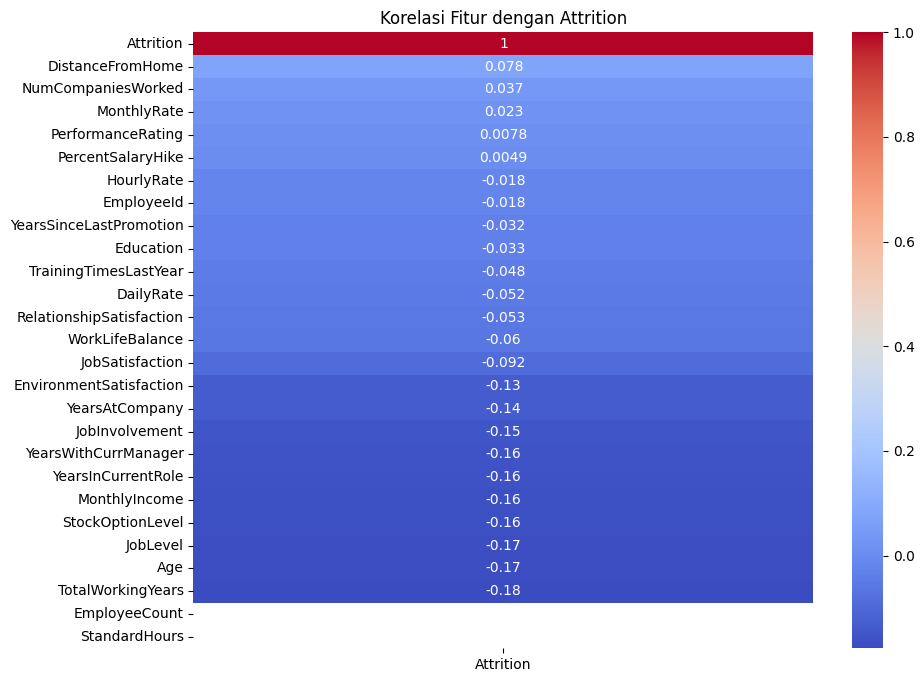

In [30]:
# Korelasi Fitur Numerik dengan Attrition
corr_matrix = df.corr(numeric_only=True)

# Visualisasi Korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[['Attrition']].sort_values(by='Attrition', ascending=False), annot=True, cmap="coolwarm")
plt.title("Korelasi Fitur dengan Attrition")
plt.show()

**Insight:**

Fitur dengan korelasi positif yang signifikan terhadap attrition adalah  `OverTime` disusul dengan `MaritalStatus`.

### **Korelasi Kategorikal**

In [31]:
# Cramér's V for Categorical-Categorical Correlation
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

cramers_v_results = []
for i, feature1 in enumerate(categorical_columns):
    for feature2 in categorical_columns[i+1:]:
        confusion_matrix = pd.crosstab(df[feature1], df[feature2])
        cramers_v_score = cramers_v(confusion_matrix)
        cramers_v_results.append({
            "Feature 1": feature1,
            "Feature 2": feature2,
            "Cramér's V": cramers_v_score
        })

In [32]:
cramers_v_df = pd.DataFrame(cramers_v_results)

In [33]:
cramers_v_df

,Feature 1,Feature 2,Cramér's V
0,BusinessTravel,Department,Department Human Resources 0.040028 ...
1,BusinessTravel,EducationField,EducationField Human Resources 0.309372 Li...
2,BusinessTravel,Gender,Gender Female 0.082801 Male 0.067607 d...
3,BusinessTravel,JobRole,JobRole Healthcare Representative 0.213903 ...
4,BusinessTravel,MaritalStatus,MaritalStatus Divorced 0.107103 Married ...
5,BusinessTravel,Over18,Over18 Y NaN dtype: float64
6,BusinessTravel,OverTime,OverTime No 0.052034 Yes 0.082826 dtype...
7,Department,EducationField,EducationField Human Resources 4.356730 Li...
8,Department,Gender,Gender Female 0.071005 Male 0.057975 d...
9,Department,JobRole,JobRole Healthcare Representative 3.146808 ...


**Insight:**

1. Hubungan Tinggi (Cramér's V > 0.3):
- `BusinessTravel` dan `JobRole`: Ada hubungan moderat antara frekuensi perjalanan bisnis dengan jenis pekerjaan.
- `Gender` dan `JobRole`: Ada hubungan moderat antara gender dan jenis pekerjaan.
2. Hubungan Rendah (Cramér's V < 0.3):
- Sebagian besar hubungan antar variabel kategorikal bersifat lemah, seperti hubungan antara `BusinessTravel` dengan `MaritalStatus`.

In [34]:
# Ekstrak nilai maksimum dari kolom "Cramér's V" untuk setiap baris
cramers_v_df['Max Cramér\'s V'] = cramers_v_df['Cramér\'s V'].apply(lambda x: x.max() if isinstance(x, pd.Series) else x)

# **Data Preparation / Preprocessing**

### **Menangani Missing Values**

In [35]:
df_cleaned = df.dropna(subset=['Attrition'])

In [36]:
# Convert Attrition
df_cleaned.loc[:, 'Attrition'] = df_cleaned['Attrition'].astype(int)

### **Encoding Fitur Kategorikal**

In [37]:
# 1. Filter Fitur Kategorikal Berdasarkan Hasil Chi-Square Test
# Memilih fitur kategorikal yang signifikan dengan p-value < 0.05
significant_categorical_features = chi_square_df[chi_square_df['p-value'] < 0.05]['Feature'].tolist()
print("Fitur kategorikal signifikan berdasarkan Chi-Square Test:", significant_categorical_features)

Fitur kategorikal signifikan berdasarkan Chi-Square Test: ['BusinessTravel', 'JobRole', 'MaritalStatus', 'OverTime']


In [38]:
# 2. Validasi Fitur Berdasarkan Hubungan dengan Target Menggunakan Cramér's V
# Memilih fitur dengan hubungan kuat terhadap target Attrition (Cramér's V > 0.3)
categorical_features_validated = []
for feature in significant_categorical_features:
    match = cramers_v_df[
        ((cramers_v_df['Feature 1'] == feature) & (cramers_v_df['Feature 2'] == 'Attrition')) |
        ((cramers_v_df['Feature 2'] == feature) & (cramers_v_df['Feature 1'] == 'Attrition'))
    ]
    if not match.empty:  # Jika ada match
        cramers_value = match['Max Cramér\'s V'].values[0]
        if cramers_value > 0.3:  # Cek threshold
            categorical_features_validated.append(feature)
print("Fitur kategorikal setelah validasi Cramér's V terhadap target:", categorical_features_validated)

Fitur kategorikal setelah validasi Cramér's V terhadap target: []


In [39]:
# 3. Menghapus Fitur Redundan Berdasarkan Hubungan Antar Fitur Kategorikal
# Identifikasi fitur redundan dengan hubungan sangat kuat antar fitur (Max Cramér's V > 0.8)
redundant_features = []
for _, row in cramers_v_df.iterrows():
    if row["Max Cramér's V"] > 0.8:  # Threshold redundansi
        redundant_features.append(row['Feature 2'])

# Menghapus fitur redundan dari fitur yang divalidasi
categorical_features_final = [f for f in categorical_features_validated if f not in redundant_features]
print("Fitur kategorikal final setelah menghapus redundansi:", categorical_features_final)

Fitur kategorikal final setelah menghapus redundansi: []


In [40]:
# 4. Memfilter Dataset Berdasarkan Fitur Kategorikal Final
# Dataset akhir untuk fitur kategorikal
df_filtered = df[categorical_features_final + numerical_columns + ['Attrition']]
print("Dataset setelah memfilter fitur kategorikal final:", df_filtered.head())

Dataset setelah memfilter fitur kategorikal final:    EmployeeId  Age  Attrition  DailyRate  DistanceFromHome  Education  \
0           1   38        NaN       1444                 1          4   
1           2   37        1.0       1141                11          2   
2           3   51        1.0       1323                 4          4   
3           4   42        0.0        555                26          3   
4           5   40        NaN       1194                 2          4   

   EmployeeCount  EnvironmentSatisfaction  HourlyRate  JobInvolvement  ...  \
0              1                        4          88               3  ...   
1              1                        1          61               1  ...   
2              1                        1          34               3  ...   
3              1                        3          77               3  ...   
4              1                        3          98               3  ...   

   StandardHours  StockOptionLevel  Total

In [41]:
# 5. Encoding Fitur Kategorikal
# Melakukan encoding pada fitur kategorikal yang tersisa
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
for feature in categorical_features_final:
    df_filtered[feature] = encoder.fit_transform(df_filtered[feature])

print("Fitur kategorikal setelah di-encode:", df_filtered[categorical_features_final].head())

Fitur kategorikal setelah di-encode: Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]


### **Scaling Fitur Numerik**

In [42]:
scaler = MinMaxScaler()

numerical_features = [
    'Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome',
    'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears',
    'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole',
    'YearsSinceLastPromotion', 'YearsWithCurrManager'
]

df_cleaned[numerical_features] = scaler.fit_transform(df_cleaned[numerical_features])


### **Verifikasi dataset**

In [43]:
prepared_dataset_info = df_cleaned.info()
prepared_dataset_head = df_cleaned.head()
prepared_dataset_missing = df_cleaned.isnull().sum()
prepared_dataset_describe = df_cleaned.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 1058 entries, 1 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmployeeId                1058 non-null   int64  
 1   Age                       1058 non-null   float64
 2   Attrition                 1058 non-null   float64
 3   BusinessTravel            1058 non-null   object 
 4   DailyRate                 1058 non-null   float64
 5   Department                1058 non-null   object 
 6   DistanceFromHome          1058 non-null   float64
 7   Education                 1058 non-null   int64  
 8   EducationField            1058 non-null   object 
 9   EmployeeCount             1058 non-null   int64  
 10  EnvironmentSatisfaction   1058 non-null   int64  
 11  Gender                    1058 non-null   object 
 12  HourlyRate                1058 non-null   float64
 13  JobInvolvement            1058 non-null   int64  
 14  JobLevel     

In [44]:
prepared_dataset_head

,EmployeeId,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1,2,0.452381,1.0,Travel_Rarely,0.743737,Research & Development,0.357143,2,Medical,1,...,1,80,0,0.375,0.333333,1,0.025,0.000000,0.000000,0.000000
2,3,0.785714,1.0,Travel_Rarely,0.874016,Research & Development,0.107143,4,Life Sciences,1,...,3,80,3,0.450,0.333333,4,0.250,0.000000,0.133333,0.411765
3,4,0.571429,0.0,Travel_Frequently,0.324266,Sales,0.892857,3,Marketing,1,...,4,80,1,0.575,0.333333,4,0.500,0.222222,0.266667,0.470588
6,7,0.523810,0.0,Travel_Rarely,0.731568,Sales,0.000000,2,Medical,1,...,3,80,3,0.150,0.333333,2,0.100,0.166667,0.000000,0.117647
7,8,0.880952,1.0,Travel_Rarely,0.445956,Research & Development,0.035714,3,Medical,1,...,4,80,1,0.600,0.333333,3,0.125,0.111111,0.066667,0.235294


In [45]:
prepared_dataset_missing

,0
EmployeeId,0
Age,0
Attrition,0
BusinessTravel,0
DailyRate,0
Department,0
DistanceFromHome,0
Education,0
EducationField,0
EmployeeCount,0


In [46]:
prepared_dataset_describe

,EmployeeId,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.0,1058.000000,1058.000000,1058.00000,...,1058.000000,1058.0,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000
mean,736.656900,0.453709,0.169187,0.506473,0.284938,2.879017,1.0,2.712665,0.509195,2.73724,...,2.726843,80.0,0.762760,0.285893,0.461563,2.763705,0.176630,0.236715,0.146881,0.243690
std,427.440538,0.224058,0.375094,0.292397,0.287165,1.031442,0.0,1.092959,0.290355,0.70473,...,1.090970,0.0,0.837537,0.200411,0.217115,0.707392,0.156631,0.200971,0.217797,0.211708
min,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,1.000000,0.000000,1.00000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,364.250000,0.285714,0.000000,0.260021,0.035714,2.000000,1.0,2.000000,0.257143,2.00000,...,2.000000,80.0,0.000000,0.150000,0.333333,2.000000,0.075000,0.111111,0.000000,0.117647
50%,731.500000,0.428571,0.000000,0.512169,0.214286,3.000000,1.0,3.000000,0.500000,3.00000,...,3.000000,80.0,1.000000,0.250000,0.500000,3.000000,0.125000,0.166667,0.066667,0.176471
75%,1117.750000,0.595238,0.000000,0.763422,0.428571,4.000000,1.0,4.000000,0.757143,3.00000,...,4.000000,80.0,1.000000,0.400000,0.500000,3.000000,0.225000,0.388889,0.200000,0.411765
max,1470.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.0,4.000000,1.000000,4.00000,...,4.000000,80.0,3.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
df_cleaned

,EmployeeId,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1,2,0.452381,1.0,Travel_Rarely,0.743737,Research & Development,0.357143,2,Medical,1,...,1,80,0,0.375,0.333333,1,0.025,0.000000,0.000000,0.000000
2,3,0.785714,1.0,Travel_Rarely,0.874016,Research & Development,0.107143,4,Life Sciences,1,...,3,80,3,0.450,0.333333,4,0.250,0.000000,0.133333,0.411765
3,4,0.571429,0.0,Travel_Frequently,0.324266,Sales,0.892857,3,Marketing,1,...,4,80,1,0.575,0.333333,4,0.500,0.222222,0.266667,0.470588
6,7,0.523810,0.0,Travel_Rarely,0.731568,Sales,0.000000,2,Medical,1,...,3,80,3,0.150,0.333333,2,0.100,0.166667,0.000000,0.117647
7,8,0.880952,1.0,Travel_Rarely,0.445956,Research & Development,0.035714,3,Medical,1,...,4,80,1,0.600,0.333333,3,0.125,0.111111,0.066667,0.235294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1464,1465,0.238095,1.0,Non-Travel,0.904796,Research & Development,0.821429,2,Technical Degree,1,...,1,80,0,0.250,0.333333,2,0.250,0.388889,0.066667,0.529412
1465,1466,0.476190,0.0,Travel_Rarely,0.047244,Research & Development,0.000000,3,Life Sciences,1,...,4,80,0,0.250,0.666667,4,0.025,0.000000,0.000000,0.000000
1467,1468,0.238095,1.0,Travel_Rarely,0.989979,Research & Development,0.392857,1,Life Sciences,1,...,4,80,0,0.025,0.666667,2,0.025,0.055556,0.000000,0.000000
1468,1469,0.523810,0.0,Non-Travel,0.254832,Research & Development,0.535714,2,Life Sciences,1,...,2,80,1,0.150,0.000000,3,0.100,0.111111,0.000000,0.000000



### **Melakukan Feature Selection dengan RFE**

In [48]:
# Define features (X) and target (y)
X = df_cleaned.drop(columns='Attrition')
y = df_cleaned['Attrition']

In [49]:
# One-hot encoding for categorical features
categorical_features = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

In [50]:
# Recursive Feature Elimination (RFE) for Feature Selection
rfe_selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=10, step=1)
rfe_selector = rfe_selector.fit(X_encoded, y)

In [51]:
# Select top features
selected_features = X_encoded.columns[rfe_selector.support_]
X_selected = X_encoded[selected_features]

In [52]:
X_selected

,EmployeeId,Age,DailyRate,DistanceFromHome,HourlyRate,MonthlyIncome,MonthlyRate,TotalWorkingYears,YearsAtCompany,OverTime_Yes
1,2,0.452381,0.743737,0.357143,0.442857,0.198420,0.493395,0.375,0.025,False
2,3,0.785714,0.874016,0.107143,0.057143,0.076461,0.330777,0.450,0.250,True
3,4,0.571429,0.324266,0.892857,0.671429,0.659084,0.512748,0.575,0.500,False
6,7,0.523810,0.731568,0.000000,0.385714,0.339547,0.448866,0.150,0.100,True
7,8,0.880952,0.445956,0.035714,0.685714,0.992628,0.767115,0.600,0.125,True
...,...,...,...,...,...,...,...,...,...,...
1464,1465,0.238095,0.904796,0.821429,0.600000,0.406161,0.412006,0.250,0.250,False
1465,1466,0.476190,0.047244,0.000000,0.728571,0.360821,0.534150,0.250,0.025,True
1467,1468,0.238095,0.989979,0.392857,0.700000,0.079305,0.837623,0.025,0.025,True
1468,1469,0.523810,0.254832,0.535714,0.628571,0.133491,0.258502,0.150,0.100,False


**Insight:**

**Hasil Analisis Interaksi Fitur**

Dari visualisasi scatterplot `MonthlyIncome` vs `Age` dengan pengaruh `OverTime` dan `Attrition`:
1. `MonthlyIncome`:
Karyawan dengan pendapatan rendah cenderung memiliki attrition lebih tinggi (ditunjukkan oleh titik berwarna oranye).
2. `Age`:
Karyawan yang lebih muda tampaknya lebih rentan keluar, terutama jika pendapatan mereka rendah.
3. `OverTime`:
`OverTime` (lembur) ditandai dengan simbol "X".
Karyawan yang lembur cenderung tersebar di area pendapatan rendah dan usia muda, dan banyak di antaranya memiliki attrition tinggi.

- Kombinasi antara usia muda, pendapatan rendah, dan lembur memperbesar risiko attrition.
- Ini menekankan pentingnya keseimbangan beban kerja dan kebijakan kompensasi untuk karyawan muda dengan pendapatan rendah.

### **Menerapkan balancing data menggunakan SMOTE**

In [53]:
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_selected, y)

### **Membagi data menjadi train-test split**

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [55]:
data_summary = {
    "Selected Features": list(selected_features),
    "X_train Shape": X_train.shape,
    "X_test Shape": X_test.shape,
    "y_train Distribution": y_train.value_counts(),
    "y_test Distribution": y_test.value_counts()
}

In [56]:
data_summary

{'Selected Features': ['EmployeeId',
  'Age',
  'DailyRate',
  'DistanceFromHome',
  'HourlyRate',
  'MonthlyIncome',
  'MonthlyRate',
  'TotalWorkingYears',
  'YearsAtCompany',
  'OverTime_Yes'],
 'X_train Shape': (1406, 10),
 'X_test Shape': (352, 10),
 'y_train Distribution': Attrition
 1.0    705
 0.0    701
 Name: count, dtype: int64,
 'y_test Distribution': Attrition
 0.0    178
 1.0    174
 Name: count, dtype: int64}

# **Modeling**

### **Baseline Model: Logistic Regression**

In [57]:
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [58]:
y_pred_logistic = logistic_model.predict(X_test)

### **Advanced Models: Random Forest**

In [59]:
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [60]:
y_pred_rf = rf_model.predict(X_test)

### **Advanced Models: XGBoost**

In [61]:
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [62]:
y_pred_xgb = xgb_model.predict(X_test)

### **Advanced Models: SVM**

In [63]:
svm_model = SVC(random_state=42, kernel='rbf')
svm_model.fit(X_train, y_train)

SVC(random_state=42)

In [64]:
y_pred_svm = svm_model.predict(X_test)

# **Evaluation**

In [65]:
# Metrics Logistic Regression
logistic_accuracy = accuracy_score(y_test, y_pred_logistic)
logistic_precision = precision_score(y_test, y_pred_logistic)
logistic_recall = recall_score(y_test, y_pred_logistic)
logistic_f1 = f1_score(y_test, y_pred_logistic)

In [66]:
# Metrics Random Forest
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

In [67]:
# Metrics XGBoost
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_precision = precision_score(y_test, y_pred_xgb)
xgb_recall = recall_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)

In [68]:
# Metrics SVM
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm)
svm_recall = recall_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)

In [69]:
model_comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "SVM"],
    "Accuracy": [logistic_accuracy, rf_accuracy, xgb_accuracy, svm_accuracy],
    "Precision": [logistic_precision, rf_precision, xgb_precision, svm_precision],
    "Recall": [logistic_recall, rf_recall, xgb_recall, svm_recall],
    "F1-Score": [logistic_f1, rf_f1, xgb_f1, svm_f1]
})

In [70]:
model_comparison

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.744318,0.741379,0.741379,0.741379
1,Random Forest,0.818182,0.823529,0.804598,0.813953
2,XGBoost,0.849432,0.853801,0.839080,0.846377
3,SVM,0.502841,0.497758,0.637931,0.559194


In [71]:
# Classification Reports
print("\nClassification Report: Logistic Regression")
print(classification_report(y_test, y_pred_logistic))

print("\nClassification Report: Random Forest")
print(classification_report(y_test, y_pred_rf))

print("\nClassification Report: XGBoost")
print(classification_report(y_test, y_pred_xgb))

print("\nClassification Report: SVM")
print(classification_report(y_test, y_pred_svm))


Classification Report: Logistic Regression
              precision    recall  f1-score   support

         0.0       0.75      0.75      0.75       178
         1.0       0.74      0.74      0.74       174

    accuracy                           0.74       352
   macro avg       0.74      0.74      0.74       352
weighted avg       0.74      0.74      0.74       352


Classification Report: Random Forest
              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82       178
         1.0       0.82      0.80      0.81       174

    accuracy                           0.82       352
   macro avg       0.82      0.82      0.82       352
weighted avg       0.82      0.82      0.82       352


Classification Report: XGBoost
              precision    recall  f1-score   support

         0.0       0.85      0.86      0.85       178
         1.0       0.85      0.84      0.85       174

    accuracy                           0.85       352
   macro avg  

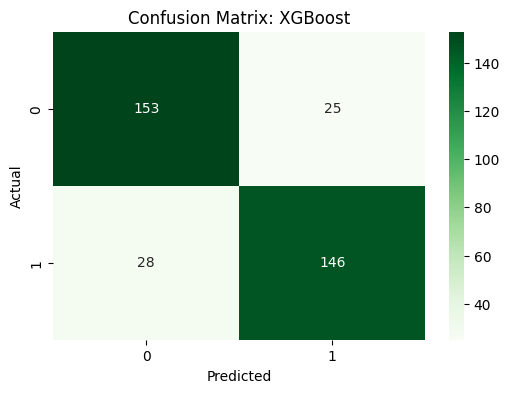

In [72]:
# Confusion Matrix Visualization XGBoost
xgb_confusion_matrix = sklearn_confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(xgb_confusion_matrix, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix: XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [73]:
# SHAP values model XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

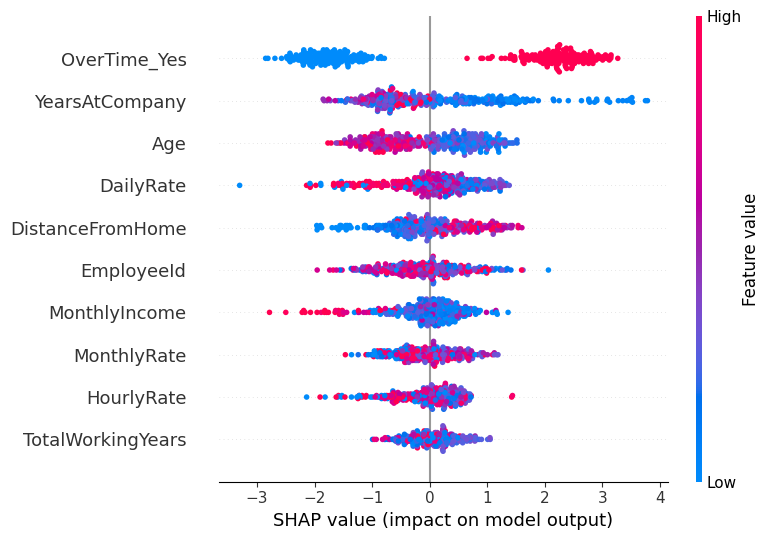

In [74]:
# Visualisasi feature importance
shap.summary_plot(shap_values, X_test)

### **Berkas Model**

In [75]:
import pickle
pickle.dump(xgb_model, open('best_model.pkl', 'wb'))

# **Interpretation**

In [76]:
# Mengambil feature importance dari model Random Forest
feature_importances = xgb_model.feature_importances_

In [77]:
# Membuat DataFrame untuk feature importance
importance_df = pd.DataFrame({
    'Feature': X_selected.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

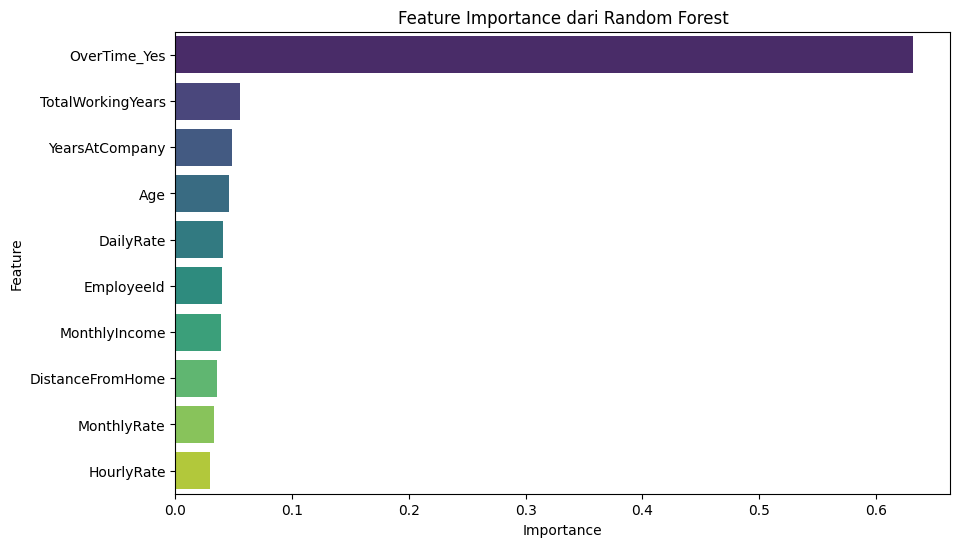

In [78]:
# Visualisasi Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")
plt.title("Feature Importance dari Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [79]:
importance_df

,Feature,Importance
9,OverTime_Yes,0.632195
7,TotalWorkingYears,0.055494
8,YearsAtCompany,0.048570
1,Age,0.045832
2,DailyRate,0.040422
0,EmployeeId,0.040049
5,MonthlyIncome,0.038795
3,DistanceFromHome,0.035489
6,MonthlyRate,0.033188
4,HourlyRate,0.029966


In [80]:
# Misalkan kita kurangi lembur
X_test_reduced_overtime = X_test.copy()
X_test_reduced_overtime['OverTime_Yes'] = 0  # Anggap lembur dikurangi

In [81]:
# Prediksi ulang dengan XGBoost
y_pred_reduced_overtime = xgb_model.predict(X_test_reduced_overtime)

In [82]:
print("Laporan Evaluasi Setelah Pengurangan Lembur")
print(classification_report(y_test, y_pred_reduced_overtime))

Laporan Evaluasi Setelah Pengurangan Lembur
              precision    recall  f1-score   support

         0.0       0.63      0.98      0.77       178
         1.0       0.96      0.42      0.58       174

    accuracy                           0.70       352
   macro avg       0.80      0.70      0.68       352
weighted avg       0.80      0.70      0.68       352



# **Conclusion**

Tujuan dari proyek ini adalah mengevaluasi penyebab utama attrition karyawan di perusahaan Jaya Jaya Maju dan membangun model untuk memprediksi karyawan yang berisiko tinggi keluar dari perusahaan. Berikut adalah temuan utama dan insight yang diperoleh:

**Faktor-Faktor Penyebab Attrition**

Berdasarkan analisis data dan model prediktif, berikut adalah faktor utama yang memengaruhi attrition:
- `OverTime`: Karyawan yang sering lembur (`OverTime` = Yes) memiliki risiko keluar yang jauh lebih tinggi dibandingkan yang tidak lembur. Fitur ini adalah prediktor terkuat dalam model prediktif.
- `MonthlyIncome`: Pendapatan bulanan yang lebih rendah meningkatkan risiko keluar karyawan. Fitur ini mencerminkan pentingnya kepuasan finansial dalam retensi karyawan.
- `YearsAtCompany` dan `TotalWorkingYears`: Masa kerja pendek baik di perusahaan maupun secara total adalah indikator risiko tinggi.
- Fitur Pendukung Lain: Fitur seperti `DistanceFromHome` dan `Age` memiliki kontribusi kecil, tetapi tetap relevan dalam memahami pola attrition.

**Model Prediktif Terbaik**

Model terbaik yang digunakan dalam proyek ini adalah XGBoost, dengan metrik performa sebagai berikut:

- Accuracy: 84.94%
- Precision: 85.38%
- Recall: 83.91%
- F1-Score: 84.63%, Model ini menunjukkan performa superior dibandingkan model lainnya seperti Logistic Regression, Random Forest, dan SVM.

**Feature Importance**

Dari analisis feature importance menggunakan model XGBoost:

- `OverTime_Yes` adalah fitur dengan kontribusi terbesar terhadap prediksi.
- `MonthlyIncome` dan `TotalWorkingYears` juga memiliki peran penting.
- Hasil ini memberikan wawasan konkret untuk fokus pada pengelolaan beban kerja dan skala gaji.

### **Pertanyaan Bisnis**

1. Apa faktor utama yang memengaruhi attrition?
- Faktor utama adalah `OverTime`, `MonthlyIncome`, dan `YearsAtCompany`.
2. Bagaimana tingkat kepuasan karyawan memengaruhi attrition?
- Fitur seperti `JobSatisfaction` tidak signifikan dalam model prediktif, tetapi tetap relevan secara deskriptif.
3. Apa pola perilaku karyawan dengan risiko keluar tinggi?
- Karyawan yang lembur berlebihan, memiliki pendapatan rendah, dan masa kerja pendek cenderung memiliki risiko tinggi.
4. Apakah kita memiliki alat bantu untuk memantau attrition?
- Model prediktif dan visualisasi hasil dapat digunakan untuk membangun dashboard interaktif untuk monitoring risiko.

### **Karakteristik Umum Karyawan yang Melakukan Attrition**

Berdasarkan analisis data, berikut adalah karakteristik umum karyawan yang melakukan attrition:

1. Demografis:
- Usia: Rata-rata usia karyawan yang keluar adalah 33 tahun.
- Jenis Kelamin: Mayoritas adalah pria (Male).
- Status Pernikahan: Sebagian besar karyawan yang keluar adalah Single, diikuti oleh Married.
2. Pekerjaan dan Departemen:
- Peran Kerja: Posisi yang paling sering melakukan attrition adalah Laboratory Technician.
- Departemen: Departemen Research & Development memiliki tingkat attrition tertinggi.
3. Faktor Finansial dan Beban Kerja:
- Pendapatan: Rata-rata pendapatan bulanan karyawan yang keluar adalah 4,872.
- Lembur (`OverTime`): Sebagian besar karyawan yang keluar bekerja lembur secara signifikan.
4. Kepuasan dan Keseimbangan:
- Kepuasan Kerja: Rata-rata tingkat kepuasan kerja adalah 2.5 (Medium).
- Keseimbangan Kerja-Hidup: Rata-rata berada di tingkat 2.67 (Moderate).
5. Masa Kerja:
- Masa Kerja di Perusahaan: Rata-rata masa kerja adalah 5 tahun, dengan beberapa karyawan memiliki masa kerja sangat panjang hingga 40 tahun.

### **Rekomendasi Action Items untuk Perusahaan**
1. **Kurangi Lembur Berlebihan**:
Berikan program kerja fleksibel untuk meningkatkan keseimbangan kerja-hidup.
2. **Kaji Skala Gaji**:
Sesuaikan gaji karyawan agar kompetitif di pasar dan berikan insentif tambahan.
3. **Perkuat Retensi Karyawan Baru**:
Implementasikan program onboarding dan mentoring untuk karyawan dengan masa kerja pendek.
4. **Gunakan Model Prediktif**:
Integrasikan model XGBoost untuk memonitor risiko secara real-time melalui dashboard HR.